In [3]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

import matplotlib.pyplot as plt

import os
import requests
import hashlib
import gzip

Populating the interactive namespace from numpy and matplotlib


In [8]:
# url = http://yann.lecun.com/exdb/mnist/
# load data (Downloaded from the above link)
def load(fp):
    if os.path.isfile(fp):
        with open(fp, 'rb') as f:
            data = f.read()
    else:
        RuntimeError("Please Download the File")
    
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X_train = load('train-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
X_test = load('t10k-images-idx3-ubyte.gz')[0x10:].reshape((-1, 28, 28))
y_train = load('train-labels-idx1-ubyte.gz')[8:]
y_test = load('t10k-labels-idx1-ubyte.gz')[8:]

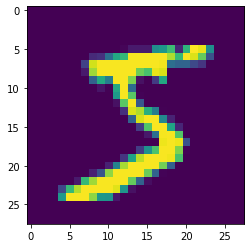

In [14]:
# Check 
plt.imshow(X_train[0])

In [10]:
# For Comparision using Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.softmax = nn.LogSoftmax(dim=1)
    
    # Forward Pass
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.softmax(x)
        return x

### Train Net (PyTorch)

Using nn.NLLLoss as a Loss_Fn
1. <b>NLLLoss</b>

    The negative log likelihood loss. It is useful to train a classification problem with C classes.

    If provided, the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.
    
Using Stochastic Gradient Descent 

<b>SGD</b>
* Implements stochastic gradient descent (optionally with momentum).

loss 0.20 accuracy 0.93: 100%|██████████████████████| 2000/2000 [00:13<00:00, 151.05it/s]


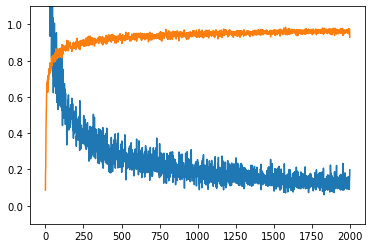

In [31]:
# train
model = Net()

# ******** I didn't know either **********************
# protip: if you like accuracy like 96 not like 93, next time through the notebook, consider
# CHAD MODE WEIGHT INIT WITH NUMPY
# instead of virgin torch init mode
# TODO: why is torch linear init bad?
# ****************************************************

loss_fn = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 512 # Batch Size
losses, accuracies = [], []

for i in (t := trange(2000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(y_train[samp]).long()
    model.zero_grad() # Set grad to zero for backpropogation
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_fn(out, Y)
    loss = loss.mean()
    loss.backward() # backward pass
    optim.step()
    
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description('loss %.2f accuracy %.2f'% (loss, accuracy))

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [32]:
# By Hit and trial method on BS and trange differnet accuracies are coming

# eval
y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(y_test == y_test_preds).mean()

0.9412

### Compute the gradients in torch

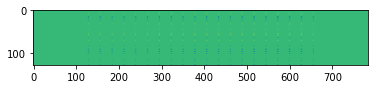

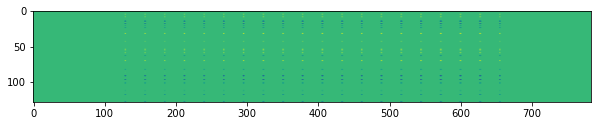

In [33]:
samp = [0, 1, 2, 3]
model.zero_grad() # Set gradients to zero
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_fn(out, torch.tensor(y_test[samp]).long()).mean()
loss.backward()

plt.imshow(model.l1.weight.grad)
plt.figure(figsize=(10, 10))
plt.imshow(model.l1.weight.grad)

# For numpy

In [34]:
# Copy weights from torch
l1 = model.l1.weight.detach().numpy().T # T -> Transpose
l2 = model.l2.weight.detach().numpy().T


# Forward Pass (Numpy)
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0) # relu
    x = x.dot(l2)
    return x

def np_eval():
    y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    y_test_preds = np.argmax(y_test_preds_out, axis=1)
    return (y_test == y_test_preds).mean()


np_eval()

0.9412

In [36]:
# Write forward and backward pass for numpy

def logsumexp(x):
    # normalization trick
    # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
    c = x.max(axis=1)
    return c + np.log(np.exp(x - c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
    # training
    out = np.zeros((len(y), 10), np.float32)
    out[range(out.shape[0]), y] = 1
    
    # Forward Pass
    x_l1 = x.dot(l1)
    x_relu = np.maximum(x_l1, 0)
    x_l2 = x_relu.dot(l2)
    x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1)) # lsm -> logsoftmax
    x_loss = (-out * x_lsm).mean(axis=1)
    
    # Backward pass
    d_out = -out / len(y)
    
    # Derivative of logsoftmax
    # Generic LogSoftMax Function
    '''
    lsm(xi) = log(exp(xi) / Sum(exp(xj)))
    '''
    
    dx_lsm = d_out - np.exp(x_lsm) * d_out.sum(axis=1).reshape((-1, 1))
    
    # Derivative of l2
    d_l2 = x_relu.T.dot(dx_lsm)
    dx_relu = dx_lsm.dot(l2.T)
    
    # Derivative of relu
    dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu
    
    # Derivative of l1
    d_l1 = x.T.dot(dx_l1)
    
    return x_loss, x_l2, d_l1, d_l2

samp = [0, 1, 2, 3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), y_test[samp])

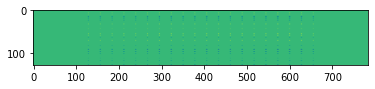

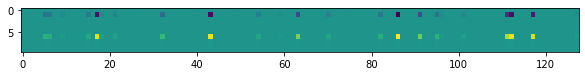

In [41]:
plt.imshow(d_l1.T)
plt.figure(figsize=(10, 10))
plt.imshow(d_l2.T)

loss 0.01 accuracy 0.98: 100%|██████████████████████| 1000/1000 [00:02<00:00, 412.03it/s]


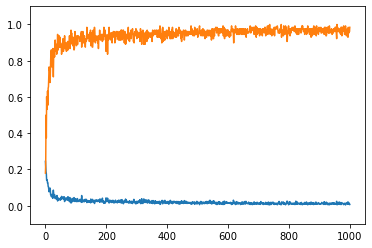

In [44]:
# Train with Numpy
def layer_init(m, h):
    ret = np.random.uniform(-1., 1., size=(m, h)) / np.sqrt(m*h)
    return ret.astype(np.float32) # Convert layer's dtype 

# init
np.random.seed(1337) # Makes random numbers predictable
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001 # learning rate
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = X_train[samp].reshape((-1, 28*28))
    Y = y_train[samp]
    
    x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y) # Forward and backward pass
    
    cat = np.argmax(x_l2, axis=1)
    accuracy = (cat == Y).mean()
    
    # SGD
    l1 -= lr*d_l1
    l2 -= lr*d_l2
    
    loss = x_loss.mean()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description('loss %.2f accuracy %.2f' % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [45]:
# Evaluate 
np_eval()
# np's accuracy is higher than torch's accuracy

0.9635

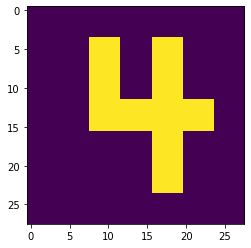

In [79]:
# Test it
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]

#m = X_test[0].reshape(28, 28)
# resize to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
#plt.imshow(m.reshape)
plt.imshow(m.reshape((28, 28)))

In [80]:
# Check
x = m.reshape(1, -1).dot(l1)
x = np.maximum(x, 0) # relu
x = x.dot(l2)

np.argmax(x)

4

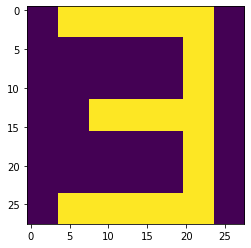

In [82]:
m1 =[[0,1,1,1,1,1,0],
     [0,0,0,0,0,1,0],
     [0,0,0,0,0,1,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,0,1,0],
     [0,0,0,0,0,1,0],
     [0,1,1,1,1,1,0]]
m1 = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m1])

plt.imshow(m1.reshape((28, 28)))

In [83]:
x = m1.reshape(1, -1).dot(l1)
x = np.maximum(x, 0) # relu
x = x.dot(l2)

np.argmax(x)

3